In [128]:
import sys
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

project_root = Path("/Users/dpro/projects/food_desert")

src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from food_desert import paths  # noqa: F401

mask_path = project_root / "data" / "interim" / "parcel_nearest_grocer_mask.csv"
neigh_path = project_root / "data" / "reference" / "neighbourhoods.csv"
pov_path = project_root / "data" / "reference" / "neighbourhoods_with_poverty.csv"

df = pd.read_csv(mask_path)

# distance in km for readability
df["dist_km"] = df["dist_to_grocer_m"] / 1000
df.head()


,Roll Number,neighbourhood_id,name,population,residents,dist_to_grocer_m,grocer_chain,grocer_store,dist_km
0,1000001000,93,Wilkes South,815,2,1779.519861,Red-River Co-op,Seasons,1.779520
1,1000005500,93,Wilkes South,815,6,1634.613819,Red-River Co-op,Seasons,1.634614
2,1000008000,93,Wilkes South,815,1,1590.978720,Red-River Co-op,Seasons,1.590979
3,1000008200,93,Wilkes South,815,4,1562.186218,Red-River Co-op,Seasons,1.562186
4,1000008400,93,Wilkes South,815,2,1519.454985,Red-River Co-op,Seasons,1.519455


## Metric 1 – people farther than 500 m per neighbourhood

In [91]:
threshold_m = 500

df["far_500"] = df["dist_to_grocer_m"] > threshold_m

group_cols = ["neighbourhood_id", "name"]

agg_500 = (
    df.groupby(group_cols, as_index=False)
      .agg(
          residents_total=("residents", "sum"),
          residents_far_500=("residents", lambda s: s[df.loc[s.index, "far_500"]].sum()),
      )
)

agg_500["share_far_500"] = agg_500["residents_far_500"] / agg_500["residents_total"]
agg_500.head(50)


,neighbourhood_id,name,residents_total,residents_far_500,share_far_500
0,2,Central River Heights,3205,3205,1.000000
1,7,Montcalm,5520,2283,0.413587
2,17,Vista,1370,513,0.374453
3,19,Ebby-Wentworth,655,371,0.566412
4,21,Shaughnessy Park,2730,2026,0.742125
5,24,Garden City,6475,4894,0.755830
6,25,Weston Shops,0,0,NaN
7,27,Varsity View,2535,1956,0.771598
8,28,Richmond West,8190,7888,0.963126
9,30,Whyte Ridge,7295,6906,0.946676


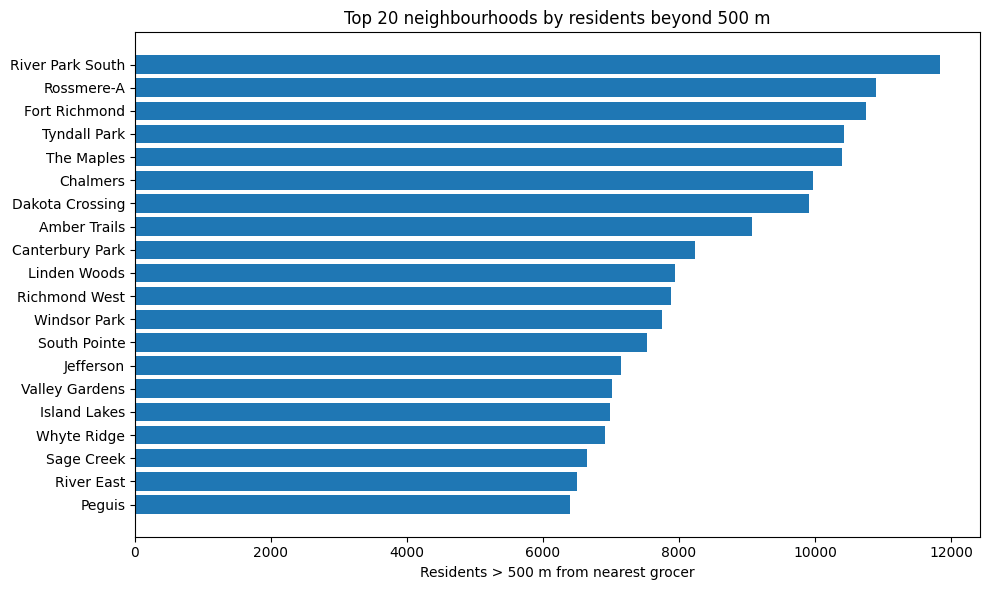

In [92]:
top_n = 20

top_500 = agg_500.sort_values("residents_far_500", ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_500["name"], top_500["residents_far_500"])
plt.gca().invert_yaxis()
plt.xlabel("Residents > 500 m from nearest grocer")
plt.title(f"Top {top_n} neighbourhoods by residents beyond 500 m")
plt.tight_layout()
plt.show()


## Metric 2 – average distance per resident (car-dependence proxy)

In [93]:
def weighted_mean_distance(group: pd.Series) -> float:
    d = df.loc[group.index, "dist_to_grocer_m"]
    w = df.loc[group.index, "residents"]
    return (d * w).sum() / w.sum()

agg_mean = (
    df.groupby(group_cols, as_index=False)
      .agg(
          residents_total=("residents", "sum"),
          dist_mean_m=("dist_to_grocer_m", weighted_mean_distance),
      )
)

agg_mean["dist_mean_km"] = agg_mean["dist_mean_m"] / 1000
agg_mean.head()


/var/folders/36/_jr9z14n69x_lzy_7969swfh0000gs/T/ipykernel_90727/4071506547.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return (d * w).sum() / w.sum()


,neighbourhood_id,name,residents_total,dist_mean_m,dist_mean_km
0,2,Central River Heights,3205,1115.934348,1.115934
1,7,Montcalm,5520,461.139970,0.461140
2,17,Vista,1370,409.736084,0.409736
3,19,Ebby-Wentworth,655,518.544161,0.518544
4,21,Shaughnessy Park,2730,663.828430,0.663828


In [94]:
neigh_stats = agg_500.merge(
    agg_mean[["neighbourhood_id", "dist_mean_m", "dist_mean_km"]],
    on="neighbourhood_id",
    how="left",
)
neigh_stats.head()


,neighbourhood_id,name,residents_total,residents_far_500,share_far_500,dist_mean_m,dist_mean_km
0,2,Central River Heights,3205,3205,1.000000,1115.934348,1.115934
1,7,Montcalm,5520,2283,0.413587,461.139970,0.461140
2,17,Vista,1370,513,0.374453,409.736084,0.409736
3,19,Ebby-Wentworth,655,371,0.566412,518.544161,0.518544
4,21,Shaughnessy Park,2730,2026,0.742125,663.828430,0.663828


## Maps – one for each metric (neighbourhood choropleths)

In [95]:
neigh_df = pd.read_csv(neigh_path)

# assume neighbourhoods.csv has WKT geometry column called "geometry"
neigh_df["geometry"] = neigh_df["geometry"].apply(wkt.loads)
neigh_gdf = gpd.GeoDataFrame(neigh_df, geometry="geometry", crs="EPSG:4326")

neigh_gdf = neigh_gdf.merge(neigh_stats, on=["neighbourhood_id", "name"], how="left")
neigh_gdf.head()


,Unnamed: 0,neighbourhood_id,name,geometry,population,residents_total,residents_far_500,share_far_500,dist_mean_m,dist_mean_km
0,0,1288,Riverview,"MULTIPOLYGON (((-97.13982 49.85457, -97.13893 ...",4265,4265.0,3127.0,0.733177,686.898197,0.686898
1,1,1722,Bridgwater Trails,"MULTIPOLYGON (((-97.20178 49.79385, -97.20306 ...",4075,4075.0,4075.0,1.000000,1547.330646,1.547331
2,2,1723,Bridgwater Lakes,"MULTIPOLYGON (((-97.19159 49.80937, -97.21967 ...",3795,3795.0,2848.0,0.750461,691.966925,0.691967
3,3,204,Meadowood,"MULTIPOLYGON (((-97.08198 49.828, -97.08198 49...",6065,6065.0,4719.0,0.778071,648.589274,0.648589
4,4,1640,Royalwood,"MULTIPOLYGON (((-97.08164 49.82773, -97.0816 4...",5125,5125.0,5125.0,1.000000,1042.479226,1.042479


(np.float64(-97.36285455297211),
 np.float64(-96.93718060730605),
 np.float64(49.699533023304),
 np.float64(50.00803059529237))

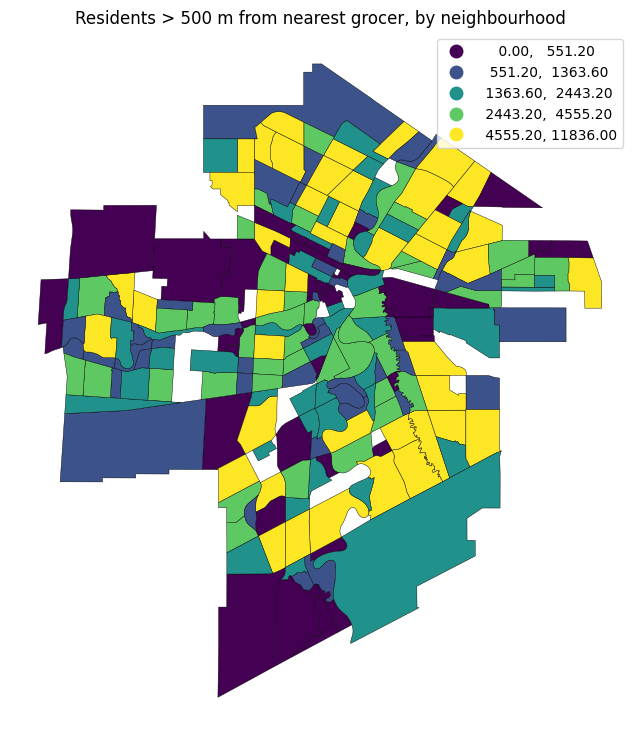

In [96]:
ax = neigh_gdf.plot(
    column="residents_far_500",
    figsize=(8, 10),
    legend=True,
    scheme="Quantiles",
    k=5,
    edgecolor="black",
    linewidth=0.3,
)
ax.set_title("Residents > 500 m from nearest grocer, by neighbourhood")
ax.axis("off")


(np.float64(-97.36285455297211),
 np.float64(-96.93718060730605),
 np.float64(49.724550043502965),
 np.float64(50.00683930861623))

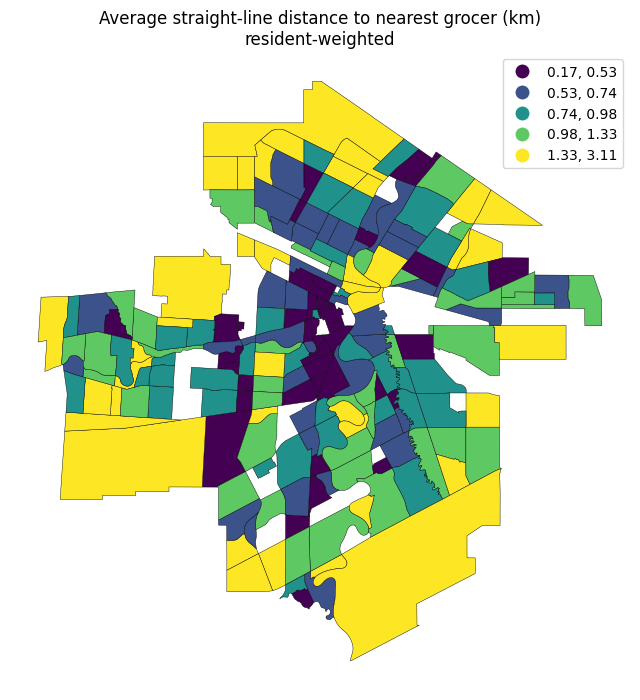

In [97]:
ax = neigh_gdf.plot(
    column="dist_mean_km",
    figsize=(8, 10),
    legend=True,
    scheme="Quantiles",
    k=5,
    edgecolor="black",
    linewidth=0.3,
)
ax.set_title("Average straight-line distance to nearest grocer (km)\nresident-weighted")
ax.axis("off")


## Confirm missing neighbourhoods

In [98]:
neigh_gdf["has_stats"] = neigh_gdf["residents_total"].notna()
neigh_gdf["has_stats"].value_counts()


has_stats
True     215
False     22
Name: count, dtype: int64

In [99]:
neigh_gdf.loc[~neigh_gdf["has_stats"], ["neighbourhood_id", "name"]].head(40)


,neighbourhood_id,name
32,139,West Fort Garry Industrial
45,161,St. Vital Centre
59,178,Parker
64,437,Omand's Creek Industrial
75,694,Kildonan Park
76,801,North Transcona Yards
92,520,Oak Point Highway
104,1126,Symington Yards
106,1074,The Forks
107,986,Tyne-Tees


# Absolute amount of people

In [100]:
threshold_m = 500

# mask parcels farther than 500 m
far_mask = df["dist_to_grocer_m"] > threshold_m

# total residents in the city
total_residents = df["residents"].sum()

# residents farther than 500 m
residents_far_500 = df.loc[far_mask, "residents"].sum()

# share (optional)
share_far_500 = residents_far_500 / total_residents


In [101]:
print(f"Total residents: {total_residents:,}")
print(f"Residents > 500 m: {residents_far_500:,}")
print(f"Share > 500 m: {share_far_500:.1%}")


Total residents: 735,235
Residents > 500 m: 562,408
Share > 500 m: 76.5%


# Poverty statistics

In [102]:
pov_df = pd.read_csv(pov_path)
pov_df.head()

,Unnamed: 0,neighbourhood_id,name,geometry,population,lim_at_pct,lico_at_pct
0,0,1288,Riverview,MULTIPOLYGON (((-97.13981596656734 49.85456680...,4265,0.082160,0.056338
1,1,1722,Bridgwater Trails,MULTIPOLYGON (((-97.20177598342603 49.79384946...,4075,0.184275,0.126536
2,2,1723,Bridgwater Lakes,MULTIPOLYGON (((-97.19159178950503 49.80936705...,3795,0.155468,0.144928
3,3,204,Meadowood,MULTIPOLYGON (((-97.08198358694017 49.82799769...,6065,0.162541,0.088284
4,4,1640,Royalwood,MULTIPOLYGON (((-97.0816385031425 49.827727867...,5125,0.041951,0.033171


In [103]:
pov_df["geometry"] = pov_df["geometry"].apply(wkt.loads)


1. Load poverty-enriched neighbourhoods and join to access stats

In [104]:
# join access stats (from parcels) with census poverty metrics
neigh_stats_pov = neigh_stats.merge(
    pov_df[["neighbourhood_id", "name", "lim_at_pct", "lico_at_pct"]],
    on=["neighbourhood_id", "name"],
    how="left",
)

neigh_stats_pov.head()


,neighbourhood_id,name,residents_total,residents_far_500,share_far_500,dist_mean_m,dist_mean_km,lim_at_pct,lico_at_pct
0,2,Central River Heights,3205,3205,1.000000,1115.934348,1.115934,0.032761,0.017161
1,7,Montcalm,5520,2283,0.413587,461.139970,0.461140,0.314312,0.291667
2,17,Vista,1370,513,0.374453,409.736084,0.409736,0.058182,0.040000
3,19,Ebby-Wentworth,655,371,0.566412,518.544161,0.518544,0.190840,0.122137
4,21,Shaughnessy Park,2730,2026,0.742125,663.828430,0.663828,0.113553,0.071429


2. Compute people in poverty per neighbourhood (LIM-AT and LICO-AT)

LIM-AT → % of people whose after-tax income is below the Low-Income Measure threshold
LICO-AT → % of people whose after-tax income is below the Low-Income Cut-Off

In [105]:
# estimated people in poverty (by census, per neighbourhood)
neigh_stats_pov["lim_at_people"] = (
    neigh_stats_pov["residents_total"] * neigh_stats_pov["lim_at_pct"]
)

neigh_stats_pov["lico_at_people"] = (
    neigh_stats_pov["residents_total"] * neigh_stats_pov["lico_at_pct"]
)


3. Compute share of residents >500 m (from parcel model)

In [106]:
neigh_stats_pov["share_far_500"] = (
    neigh_stats_pov["residents_far_500"] / neigh_stats_pov["residents_total"]
)

4. People in poverty and >500 m from a grocer (per neighbourhood)

In [107]:
# LIM-AT version
neigh_stats_pov["lim_at_people_far_500"] = (
    neigh_stats_pov["lim_at_people"] * neigh_stats_pov["share_far_500"]
)

# LICO-AT version
neigh_stats_pov["lico_at_people_far_500"] = (
    neigh_stats_pov["lico_at_people"] * neigh_stats_pov["share_far_500"]
)

neigh_stats_pov[[
    "neighbourhood_id",
    "name",
    "residents_total",
    "lim_at_pct",
    "lim_at_people",
    "residents_far_500",
    "share_far_500",
    "lim_at_people_far_500",
]].head()


,neighbourhood_id,name,residents_total,lim_at_pct,lim_at_people,residents_far_500,share_far_500,lim_at_people_far_500
0,2,Central River Heights,3205,0.032761,105.000000,3205,1.000000,105.000000
1,7,Montcalm,5520,0.314312,1735.000000,2283,0.413587,717.573370
2,17,Vista,1370,0.058182,79.709091,513,0.374453,29.847273
3,19,Ebby-Wentworth,655,0.190840,125.000000,371,0.566412,70.801527
4,21,Shaughnessy Park,2730,0.113553,310.000000,2026,0.742125,230.058608


5. City-wide totals

In [108]:
total_lim_at = neigh_stats_pov["lim_at_people"].sum()
total_lim_at_far_500 = neigh_stats_pov["lim_at_people_far_500"].sum()

total_lico_at = neigh_stats_pov["lico_at_people"].sum()
total_lico_at_far_500 = neigh_stats_pov["lico_at_people_far_500"].sum()

6. Save a clean table for mapping / analysis

In [109]:
out_pov_access = project_root / "data" / "interim" / "neighbourhood_poverty_access.csv"

cols = [
    "neighbourhood_id",
    "name",
    "residents_total",
    "lim_at_pct",
    "lico_at_pct",
    "lim_at_people",
    "lico_at_people",
    "residents_total",
    "residents_far_500",
    "share_far_500",
    "lim_at_people_far_500",
    "lico_at_people_far_500",
]

neigh_stats_pov[cols].to_csv(out_pov_access, index=False)


# Mapping poverty metrics

1. Load neighbourhood_poverty_access.csv and join to geometry

In [115]:
# load neighbourhood-level poverty + access metrics
pov_access_path = project_root / "data" / "interim" / "neighbourhood_poverty_access.csv"
pov_access_df = pd.read_csv(pov_access_path)

# reuse existing neigh_gdf (has geometry) and join poverty/access cols onto it
neigh_pov_gdf = neigh_gdf.merge(
    pov_access_df,
    on=["neighbourhood_id", "name"],
    how="left",
)

neigh_pov_gdf.head()

,Unnamed: 0,neighbourhood_id,name,geometry,population,residents_total_x,residents_far_500_x,share_far_500_x,dist_mean_m,dist_mean_km,...,residents_total_y,lim_at_pct,lico_at_pct,lim_at_people,lico_at_people,residents_total.1,residents_far_500_y,share_far_500_y,lim_at_people_far_500,lico_at_people_far_500
0,0,1288,Riverview,"MULTIPOLYGON (((-97.13982 49.85457, -97.13893 ...",4265,4265.0,3127.0,0.733177,686.898197,0.686898,...,4265.0,0.082160,0.056338,350.410798,240.281690,4265.0,3127.0,0.733177,256.913146,176.169014
1,1,1722,Bridgwater Trails,"MULTIPOLYGON (((-97.20178 49.79385, -97.20306 ...",4075,4075.0,4075.0,1.000000,1547.330646,1.547331,...,4075.0,0.184275,0.126536,750.921376,515.632678,4075.0,4075.0,1.000000,750.921376,515.632678
2,2,1723,Bridgwater Lakes,"MULTIPOLYGON (((-97.19159 49.80937, -97.21967 ...",3795,3795.0,2848.0,0.750461,691.966925,0.691967,...,3795.0,0.155468,0.144928,590.000000,550.000000,3795.0,2848.0,0.750461,442.772069,412.753623
3,3,204,Meadowood,"MULTIPOLYGON (((-97.08198 49.828, -97.08198 49...",6065,6065.0,4719.0,0.778071,648.589274,0.648589,...,6065.0,0.162541,0.088284,985.812706,535.441419,6065.0,4719.0,0.778071,767.032178,416.611386
4,4,1640,Royalwood,"MULTIPOLYGON (((-97.08164 49.82773, -97.0816 4...",5125,5125.0,5125.0,1.000000,1042.479226,1.042479,...,5125.0,0.041951,0.033171,215.000000,170.000000,5125.0,5125.0,1.000000,215.000000,170.000000


In [120]:
for col in [
    "lim_at_people_far_500",
    "lico_at_people_far_500",
    "share_far_500",
]:
    if col in neigh_pov_gdf.columns:
        neigh_pov_gdf[col] = neigh_pov_gdf[col].fillna(0)

2. a) Choropleth: LIM-AT people >500 m from a grocer

/Users/dpro/projects/food_desert/.venv/lib/python3.13/site-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 20 classes. Setting k to 17.
  self.bins = quantile(y, k=k)


(np.float64(-97.36878169753167),
 np.float64(-96.93689836232701),
 np.float64(49.699533023304),
 np.float64(50.00803059529237))

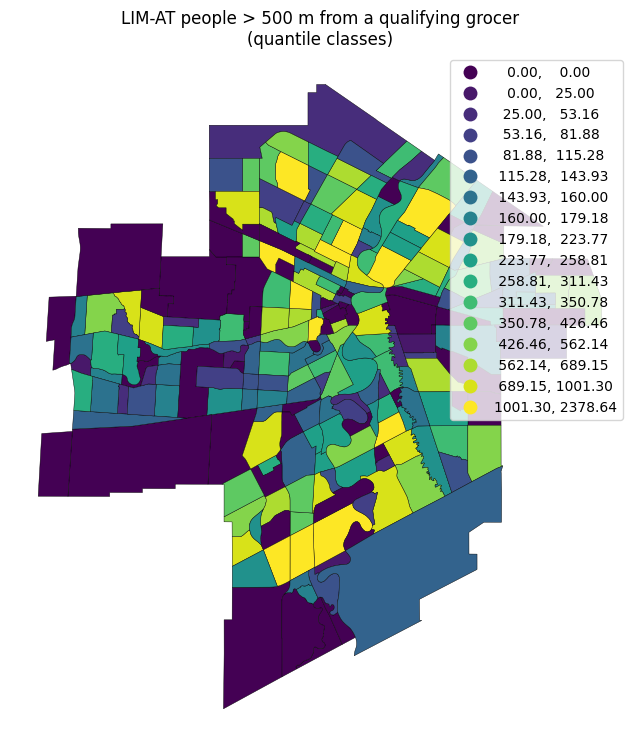

In [124]:
ax = neigh_pov_gdf.plot(
    column="lim_at_people_far_500",
    figsize=(8, 10),
    legend=True,
    scheme="Quantiles",
    k=20,
    edgecolor="black",
    linewidth=0.3,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

ax.set_title("LIM-AT people > 500 m from a qualifying grocer\n(quantile classes)")
ax.axis("off")

2. b) Choropleth: LICO-AT people >500 m from a grocer

/Users/dpro/projects/food_desert/.venv/lib/python3.13/site-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 15 classes. Setting k to 13.
  self.bins = quantile(y, k=k)


(np.float64(-97.36878169753167),
 np.float64(-96.93689836232701),
 np.float64(49.699533023304),
 np.float64(50.00803059529237))

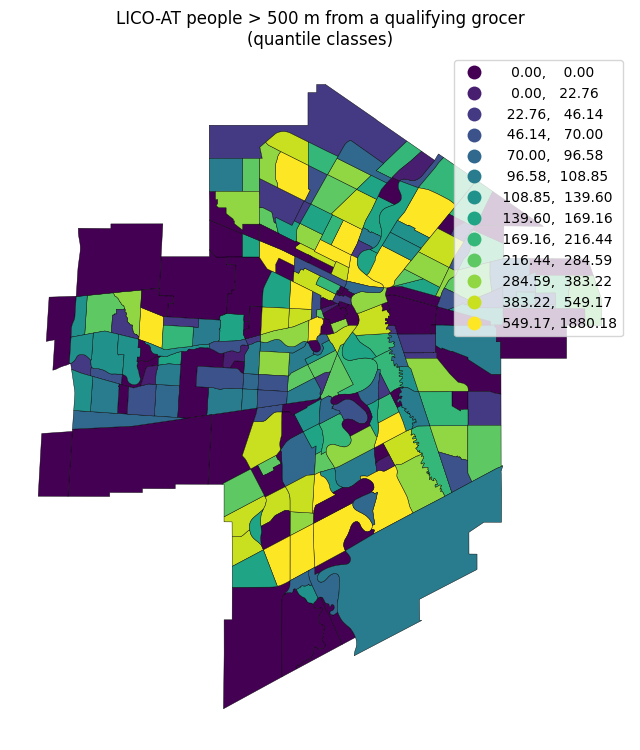

In [122]:
ax = neigh_pov_gdf.plot(
    column="lico_at_people_far_500",
    figsize=(8, 10),
    legend=True,
    scheme="Quantiles",
    k=15,
    edgecolor="black",
    linewidth=0.3,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

ax.set_title("LICO-AT people > 500 m from a qualifying grocer\n(quantile classes)")
ax.axis("off")

In [123]:
# if using neigh_stats_pov:
src = neigh_stats_pov

total_lim_at_people = src["lim_at_people"].sum()
total_lim_at_people_far_500 = src["lim_at_people_far_500"].sum()

total_lico_at_people = src["lico_at_people"].sum()
total_lico_at_people_far_500 = src["lico_at_people_far_500"].sum()

print("=== LIM-AT (low-income measure, after tax) ===")
print(f"People in poverty (LIM-AT):           {total_lim_at_people:,.0f}")
print(f"People in poverty >500 m (LIM-AT):    {total_lim_at_people_far_500:,.0f}")
print()
print("=== LICO-AT (low-income cut-off, after tax) ===")
print(f"People in poverty (LICO-AT):          {total_lico_at_people:,.0f}")
print(f"People in poverty >500 m (LICO-AT):   {total_lico_at_people_far_500:,.0f}")


=== LIM-AT (low-income measure, after tax) ===
People in poverty (LIM-AT):           94,389
People in poverty >500 m (LIM-AT):    65,473

=== LICO-AT (low-income cut-off, after tax) ===
People in poverty (LICO-AT):          60,888
People in poverty >500 m (LICO-AT):   41,874


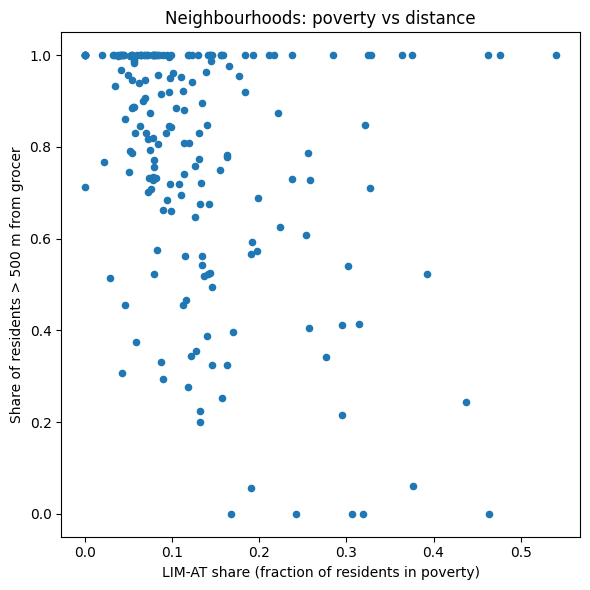

In [126]:
data = neigh_stats_pov.copy()

# keep only neighbourhoods with both poverty + distance info
mask = data["lim_at_pct"].notna() & data["share_far_500"].notna()
data = data[mask]

plt.figure(figsize=(6, 6))
plt.scatter(data["lim_at_pct"], data["share_far_500"], s=20)
plt.xlabel("LIM-AT share (fraction of residents in poverty)")
plt.ylabel("Share of residents > 500 m from grocer")
plt.title("Neighbourhoods: poverty vs distance")
plt.tight_layout()
plt.show()


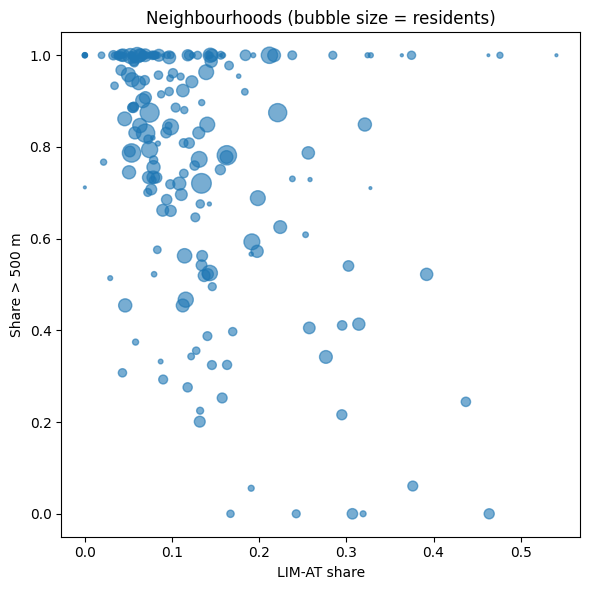

In [127]:
sizes = (data["residents_total"] / data["residents_total"].max()) * 200

plt.figure(figsize=(6, 6))
plt.scatter(data["lim_at_pct"], data["share_far_500"], s=sizes, alpha=0.6)
plt.xlabel("LIM-AT share")
plt.ylabel("Share > 500 m")
plt.title("Neighbourhoods (bubble size = residents)")
plt.tight_layout()
plt.show()


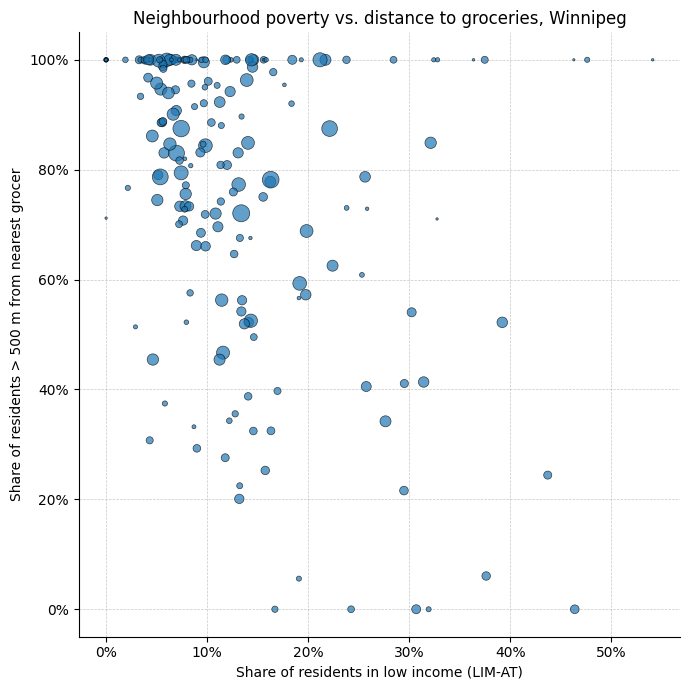

In [129]:
# bubble sizes scaled by residents
sizes = (data["residents_total"] / data["residents_total"].max()) * 150

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(
    data["lim_at_pct"],
    data["share_far_500"],
    s=sizes,
    alpha=0.7,
    linewidth=0.5,
    edgecolors="black",
)

ax.set_xlabel("Share of residents in low income (LIM-AT)")
ax.set_ylabel("Share of residents > 500 m from nearest grocer")
ax.set_title("Neighbourhood poverty vs. distance to groceries, Winnipeg")

# format axes as percents (if your data are 0–1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# light grid behind points
ax.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

# remove top/right spines for a cleaner look
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()